# Lecture 22 - Large Language Models (Part 2)

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_22-LLMs_Part_2/Lecture_22-LLMs_Part_2.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_22-LLMs_Part_2/Lecture_22-LLMs_Part_2.ipynb)

<a id='top'></a>

- [22.1 Mixture of Experts](#22.1-mixture-of-experts)
  - [22.1.1 Sparsity](#22.1.1-sparsity)
  - [22.1.2 MoE Advantages and Disadvantages](#22.1.2-moe-advantages-and-disadvantages)
- [22.2 Retrieval-Augmented Generation](#22.2-retrieval-augmented-generation)
  - [22.2.1 RAG Implementation - Example 1](#22.2.1-rag-implementation---example-1)
  - [22.2.2 RAG Implementation - Example 2](#22.2.2-rag-implementation---example-2)
- [22.3 Vision-Language Models](#22.3-vision-language-models)
  - [22.3.1 VLM Architectures](#22.3.1-vlm-architectures)
  - [22.3.2 Benchmarking VLMs](#22.3.2-benchmarking-vlms)
  - [22.3.3 VLMs Importance](#22.3.3-vlms-importance)
  - [22.3.4 VLM Finetuning](#22.3.4-vlm-finetuning)
- [Appendix: VLM Finetuning with Unsloth Library](#appendix:-vlm-finetuning-with-unsloth-library)
- [References](#references)

This lecture continues our study of Large Language Models (LLMs) by examining several advanced topics. We will discuss Mixture of Experts (MoE) architectures and Retrieval-Augmented Generation (RAG). In addition, we will cover Vision-Language Models (VLMs) as an example of multi-modal models that integrate visual and textual understanding.

## 22.1 Mixture of Experts <a name='22.1-mixture-of-experts'></a>

**Mixture of Experts (MoE)** in LLMs refers to a technique that uses a collection of sub-networks (called "experts") that jointly perform a task, with each expert specializing in learning different aspects of the task.

MoE in LLMs has similarities with Ensemble Methods in ML (e.g., Random Forests, Gradient Boosting, Bagging Ensembles), where an ensemble of models contributes to a prediction. Differently from Ensemble Methods, MoE introduces dynamic routing of the input to different experts, as well as, all experts in MoE are trained as part of a single neural architecture rather than as separate learners.

**MoE Components**

A typical MoE architecture is shown in the figure below and consists of two key components:

- **Experts**: each expert is typically a fully-connected neural network trained on different parts or properties of the input. Each expert specializes in processing different types of inputs, such as token types, contexts, or semantic patterns.

- **Router or gating network**: analyzes the inputs and determines which tokens are sent to which experts. It acts as a coordinator that routes the inputs to the selected experts.

When MoE receives input data, it first passes the data through the gating network. The gating network analyzes the input and selects the experts to receive the data. Typically, only a small subset of experts is activated for each input. The selected experts then process the data and generate outputs, which are combined to produce the final output of the MoE.

<img src="images/moe_components.png" width="400">

*Figure: Main components of MoE.* Source: [1].




In most MoE LLMs, the dense Feed-Forward Network (FFN) of Transformers is replaced with a set of experts. The **experts** are also feed-forward networks, but they are smaller compared to the FFN in Transformers. In general, experts can also be more complex than FFNs, and an expert can even be an MoE itself (known as hierarchical MoE).

<img src="images/transformer_vs_moe.gif" width="500">

*Figure: Transformer vs MoE.* Source: [2].


Because LLMs contain many decoder blocks in sequence, input tokens may pass through different experts across the decoder blocks, which results in diverse specialization patterns.

<img src="images/decoder_layers.gif" width="350">

*Figure: Experts in decoder layers.* Source: [2].



The **gating network (router)** is also a small FFN that acts like a multi-class classifier and outputs softmax scores over the experts. I.e., the router assigns a probability value to each expert, and determines which experts are activated for a given token.

For instance, in the figure, the router assigned the highest probability value to Expert-1, and selected it for routing the input data to that expert.

<img src="images/router.gif" width="450">

*Figure: Gating network (router).* Source: [1].



Training an MoE model involves updating both the experts and the gating network, which makes it more challenging than training traditional Transformer models. Specifically, the training can result in a poor routing strategy where the gating network activates only a small number of experts. Such imbalance means that the selected few experts can become overly specialized, while other experts can remain undertrained and underutilized. This imbalance reduces the performance of the entire model.

Consequently, *load balancing* by the router is critical for MoE performance. Several different strategies have been proposed that penalize overreliance on any one expert, and reward more even utilization of all experts.  

In MoE models, each expert learns a different specialization of the overall function. However, the experts do not learn completely separate tasks. Instead, they learn to handle different types of tokens, contexts, or transformations. For example, one expert may learn code-style token patterns, another may learn transformations helpful for math reasoning, then another may specialize in rare domain-specific words, and similar.



### 22.1.1 Sparsity<a name='22.1.1-sparsity'></a>


The main concept in MoE architectures is the presence of **sparse layers**, since only some of the experts (and therefore their neurons) are activated for each token. In the original **dense layers** in FFN of Transformers, all neurons are connected to every neuron in the preceding and following layers. In sparse layers, neurons are connected only to some of the neurons in the neighboring layers.

<img src="images/dense_sparse.png" width="450">

*Figure: Dense versus sparse networks.* Source: [3].

For example, Mixtral is a well-known MoE LLM that uses 8 experts, each containing approximately 7B parameters. Therefore, the FFN in Mixtral has 8 expert blocks. For every token, the gating network selects two of the eight experts to process the data. Hence, about 14B parameters (two experts) are active during training and inference. Note however, that the overall number of parameters in Mixtral is not exactly 8 x 7B = 56B, since some layers are shared. The total parameter count is around 47B.

The total number of parameters is generally considered a measure of the **model capacity**. The number of parameters that are used to process an individual token is a measure of the model's **computational cost**. Thus, Mixtral has a similar learning capacity to dense LLMs with 47B parameters, but has a much lower computational cost because only 14B parameters are used per token.

Note also that although 14B parameters are active per token, the entire Mixtral model with 47B parameters needs to be loaded into memory to perform inference. In other words, computational efficiency does not reduce the requirement for sufficient RAM/VRAM to load the model.

Other well-known MoE LLMs include Mixtral 8 x 22B, DeepSeek-V3 (671B parameters, with 37B active per token), Qwen3-235B (128 experts in total, 8 experts with 22B parameters active per token), Qwen1.5 (64 experts in total, 4 experts with 2.7B parameters active per token), etc. It is likely that the premier LLMs including GPT-5 and Claude 4 use some form of MoE and combine sparse and dense layers, although it is not known for sure.



### 22.1.2 MoE Advantages and Disadvantages<a name='22.1.2-moe-advantages-and-disadvantages'></a>

MoE models offer several important advantages in LLMs, as follows.

- Sparsity: Instead of activating the entire network for each input token, MoE activates only a small subset of parameters, and much of the model stays inactive for a given token.
- Efficient inference: Because only one or a few experts are used per token, fewer computations are required. This lowers inference-time compute and required memory.
- Faster pretraining: MoE LLMs are significantly faster to pretrain compared to dense models with the same total number of parameters, because each token uses only a fraction of the parameters.
- Higher quality outputs: Expert specialization improves accuracy and overall model performance.

MoE disadvantages include:

- Training instability: Sparse routing can lead to imbalanced expert usage, where a few experts get most of the traffic while others remain underutilized.
- Fine-tuning difficulty: Fine-tuning MoE models is more challenging due to the presence of sparse layers.
- Hardware complexity: MoE requires careful management of memory and compute, especially when experts are distributed across devices.
- Overfitting: Sparse models are more prone to overfitting than dense models if load balancing is insufficient.













## 22.2 Retrieval Augmented Generation <a name='22.2-retrieval-augmented-generation'></a>

**Retrieval Augmented Generation (RAG)** refers to the use of external sources of information for improving the generated responses by LLMs. RAG allows LLMs to retrieve facts from external sources (e.g., Wikipedia, news articles, local documents) and provide responses that are more accurate and/or are up-to-date.

In general, the internal knowledge of LLMs is static, as it is fixed by the date of the used training dataset. Therefore, LLMs cannot answer questions about current events, and they are stuck in the time moment of their training data. Updating LLMs with knowledge about current events requires to continuously retrain the models on new data. Such a process is very expensive, as it requires collecting updated datasets and finetuning the model to update the weights.

RAG enables to avoid expensive LLMs retraining, by retrieving information from external databases to generate responses. The RAG approach involves two major phases:

- **Retrieval**, includes performing relevancy search of external databases regarding a user query, and retrieving supporting documents and snippets of important information.
- **Content generation**, the retrieved supporting documents are used as a context that is appended to the user query, and are fed to the LLMs for generating the final response.

Instead of relying only on the information contained in the training dataset used for training an LLM, RAG provides an interface to external knowledge to ensure that the model has access to the most current and reliable facts. E.g., in an enterprise setting, external sources of information for RAG can comprise various company-specific files, documents, and databases. Employing RAG can result in more relevant responses and it can reduce the problem of hallucination by LLMs. It also allows the users to review the sources that were used by LLMs and verify the accuracy of generated responses. However, RAG systems have also limitations, which include potential retrieval of irrelevant or outdated documents, increased response latency due to the retrieval step, and dependency on the quality and coverage of the external knowledge sources.

An overview of a RAG system is depicted in the figure. The provided examples that follow demonstrate two different ways to implement RAG systems.

<img src="images/RAG.png" width="500">

*Figure: RAG system.* Source: [4].

### 22.2.1 RAG Implementation - Example 1<a name='22.2.1-rag-implementation---example-1'></a>

In this example, we will implement a RAG system in Python using the Hugging Face library for model loading and response generation.

As an external text source, we will use a Wikipedia article on LLMs available at https://en.wikipedia.org/wiki/Large_language_model
. The article has been pre-processed by extracting the main text content, removing sections with equations, and removing references. The cleaned text is saved in a plain text file named `wikipedia_llm.txt`.

We will build a RAG system that allows us to answer queries about the article.

#### Data Loading

First, we mount Google Drive and import the required libraries. Most are standard, except for `sentence_transformers` that is a Hugging Face library that is used to load an embedding model, and facilitate creating vector embeddings for sentences, paragraphs, or documents.

Next, we load the document `wikipedia_llm.txt`, which is uploaded in the course folder for Lecture 22 on my Google Drive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer

In [ ]:
# Path to the file uploaded on Google Drive
file_path = 'drive/MyDrive/Data_Science_Course/Fall_2025/Lectures/Lecture_22-LLMs_Part_2/data/wikipedia_llm.txt'

# Load the text file
with open(file_path , 'r') as f:
    text = f.read()

In [ ]:
# Print the text content of the article
text[:1000]

'=== Introduction ===\nA large language model (LLM) is a language model trained with self-supervised machine learning on a vast amount of text, designed for natural language processing tasks, especially language generation. The largest and most capable LLMs are generative pre-trained transformers (GPTs) and provide the core capabilities of chatbots such as ChatGPT, Gemini and Claude. LLMs can be fine-tuned for specific tasks or guided by prompt engineering. These models acquire predictive power regarding syntax, semantics, and ontologies inherent in human language corpora, but they also inherit inaccuracies and biases present in the data they are trained on.\nThey consist of billions to trillions of parameters and operate as general-purpose sequence models, generating, summarizing, translating, and reasoning over text. LLMs represent a significant new technology in their ability to generalize across tasks with minimal task-specific supervision, enabling capabilities like conversational

#### Split Text into Chunks

To prepare the document for embedding, we need to split the text into smaller chunks. RAG systems typically work with text chunks because source documents may be too long and exceed the LLM context window. Also, smaller chunks lead to more accurate embeddings, and provide more precise context for query answering.

There are several different ways of creating chunks. A common approach is to split text based on token count, where for instance, every chunk can contain 300 tokens. Since this Wikipedia article is already divided into sub-sections, we will use one sub-section per chunk.

The following function `chunk_by_section` does exactly that, using the `==` text markers to identify top-level headers and split the text into chunks.

In [ ]:
# Function to split text into chunks (each sub-section is one chunk)
def chunk_by_section(wiki_text):

    # Find all top-level headers and their content
    pattern = re.compile(r'(==\s*[^=].*?==)\s*(.*?)(?=(?:==\s*[^=].*?==)|\Z)', re.S | re.M)
    matches = pattern.findall(wiki_text)

    chunks = []
    pending_headers = []
    for header, content in matches:
        if content.strip():
            # If there are header-only sections, prepend them to non-empty sections
            if pending_headers:
                combined_header = "\n".join(pending_headers + [header])
                chunk = (combined_header + content).strip()
                pending_headers = []
            else:
                chunk = (header + content).strip()
            chunks.append(chunk)
        else:
            pending_headers.append(header)

    return chunks

In [ ]:
# Call the function to create chunks
chunks = chunk_by_section(text)

Note that there are 53 text chunks in total. The first 5 chunks are displayed in the pandas DataFrame below.

In [ ]:
# Print the number of chunks in the article
print(f"Created {len(chunks)} chunks")

Created 53 chunks


In [ ]:
# Create a pandas dataframe using the chunks
df = pd.DataFrame({"chunk_id": range(len(chunks)), "text": chunks})

# Show the first 5 chunks
df.head(5)

,chunk_id,text
0,0,== Introduction ===\nA large language model (L...
1,1,== History ===\nBefore the emergence of transf...
2,2,== Tokenization ===\nAs machine learning algor...
3,3,"== Byte-pair encoding ===\nAs an example, cons..."
4,4,== Tokenization: Problems ===\nA token vocabul...


#### Embedding

To perform RAG, we first need to create embeddings for all text chunks.  In this example, we use the `Qwen3-Embedding-0.6B` model. Each text chunk is passed through this embedding model, and an embedding vector was calculated for each of the 53 chunks. As we can notice, each embedding vector has 1,024 elements.

In [ ]:
# Load the embedding model
embed_model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')

In [ ]:
# Create embeddings for all text chunks
chunk_embeddings = embed_model.encode(chunks, prompt_name="query")

In [ ]:
# Check the shape of chunk embeddings
print(f"Shape of created embeddings: {chunk_embeddings.shape}")

Shape of created embeddings: (53, 1024)


#### Retrieval

The next step involves finding the most relevant chunks for a given query. We first obtain an embedding vector for the given query using the same model `Qwen3-Embedding-0.6B`. This results in an 1,024 dimensional embedding vector.

In [ ]:
# A test query
query = "What is a mixture of experts"

In [ ]:
# Create a vector embedding for the query
query_embedding = embed_model.encode([query], prompt_name="query")[0]

In [ ]:
# Print the shape of the embedding
query_embedding.shape

(1024,)

The next cell calculates cosine similarity between the query embedding and the embedding for each chunk. As you may recall, cosine similarity for two vectors $u$ and $v$ is calculated as $\dfrac{u\cdot v}{||u||\cdot ||v||}$.

In [ ]:
# Calculate similarity between the query embedding and each chunk embedding
# cosine similarity = dot_product(u,v) / norm(u)*norm(v)
similarities = np.dot(chunk_embeddings, query_embedding)
similarities = similarities / (np.linalg.norm(chunk_embeddings, axis=1) * np.linalg.norm(query_embedding))

In [ ]:
# Print the shape of similarities
similarities.shape

(53,)


There are 53 similarity scores since there are 53 text chunks. By sorting the similarity scores, we found that the embeddings for chunks 12, 45, and 15, are the closest to the embedding vector for the query.

In [ ]:
# Find the indices for the top 3 most similar chunks
top_indices = np.argsort(similarities)[-3:][::-1]

top_indices

array([12, 45, 15])

In the next cell, the top 3 text chunks are printed. We  see that the first chunk has a similarity score of 0.740 and it is the most relevant to the question. Notice that the sub-section header is "Mixture of experts" and it directly relates to the posed question "What is a mixture of experts". The second and third chunks have much lower similarity scores (0.248 and 0.247) and are less relevant.

In [ ]:
print(f"Results\n")
for i in top_indices:
    print(f"Similarity score: {similarities[i]:.3f}:\nText Chunk: {chunks[i][:1000]}")

Results

Similarity score: 0.740:
Text Chunk: == Mixture of experts ===
A mixture of experts (MoE) is a machine learning architecture in which multiple specialized neural networks ("experts") work together, with a gating mechanism that routes each input to the most appropriate expert(s). Mixtures of experts can reduce inference costs, as only a fraction of the parameters are used for each input. The approach was introduced in 2017 by Google researchers.


=
Similarity score: 0.248:
Text Chunk: == Sycophancy and glazing ===
Sycophancy is a model's tendency to agree with, flatter, or validate a user's stated beliefs rather than to prioritize factuality or corrective information, and "glazing" is an emergent public shorthand for persistent, excessive agreeability observed across multi-turn interactions and productized assistants.
Continued sycophancy has led to the observation of getting "1-shotted", denoting instances where conversational interaction with a large language model produces 

#### Generation

The final step in RAG uses the results from the Retrieval phase, and performs response generation. In this example, we use `Qwen3-0.6` LLM for response generation. Note that this model is different from `Qwen3-Embedding-0.6B` that we used for chunk embedding. Also note than the model is loaded with `AutoModelForCausalLM` since the task to perfom is casual language modeling. Loaded with the model is the corresponding tokenizer as well.

In [ ]:
# Load Qwen3 language model and tokenizer
lm_model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(lm_model_name)

lm_model = AutoModelForCausalLM.from_pretrained(lm_model_name, pad_token_id=tokenizer.eos_token_id)

Let's use only the top chunk to generate an answer, since it was the most relevant for the query. We assign it to the name `context`.

Afterward, we create a message for chat template that contains "system" and "user" roles. The system message below is quite general. The user message prepends the retrieved context (i.e., the most relevant text chunk) to the query. This ensures that LLM has access to the text chunk and use the information when generating the answer to the query.  

In [ ]:
context = chunks[top_indices[0]]
context

'== Mixture of experts ===\nA mixture of experts (MoE) is a machine learning architecture in which multiple specialized neural networks ("experts") work together, with a gating mechanism that routes each input to the most appropriate expert(s). Mixtures of experts can reduce inference costs, as only a fraction of the parameters are used for each input. The approach was introduced in 2017 by Google researchers.\n\n\n='

In [ ]:
# Create messages for chat template
messages = [{"role": "system", "content": "You are a helpful assistant answering questions."},
            {"role": "user", "content": f"""Use this context: {context} to answer the following question: {query}"""}]

The next cell applies the chat template for `Qwen3-0.6B` to the messages. Notice that the formatted prompt has the tags for instruction message start and end `<|im_start|>` and `<|im_end|>` added to the text, to match the expected format for `Qwen3-0.6B`.

Shown below also is the tokenized prompt with `input_ids` and `attention_mask` keys and corresponding values.

In [ ]:
# Apply chat template to build the prompt
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Diplay formatted prompt
prompt

'<|im_start|>system\nYou are a helpful assistant answering questions.<|im_end|>\n<|im_start|>user\nUse this context: == Mixture of experts ===\nA mixture of experts (MoE) is a machine learning architecture in which multiple specialized neural networks ("experts") work together, with a gating mechanism that routes each input to the most appropriate expert(s). Mixtures of experts can reduce inference costs, as only a fraction of the parameters are used for each input. The approach was introduced in 2017 by Google researchers.\n\n\n= to answer the following question: What is a mixture of experts<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to(lm_model.device)

inputs

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,  35764,
           4755,     13, 151645,    198, 151644,    872,    198,  10253,    419,
           2266,     25,    621,    386,  12735,    315,  11647,   2049,    198,
             32,  20980,    315,  11647,    320,  25612,     36,      8,    374,
            264,   5662,   6832,  17646,    304,    892,   5248,  27076,  29728,
          14155,   3489,   4580,  15546,    899,    975,   3786,     11,    448,
            264,  73399,  16953,    429,  11291,   1817,   1946,    311,    279,
           1429,   8311,   6203,   1141,    568,  19219,  18513,    315,  11647,
            646,   7949,  44378,   7049,     11,    438,   1172,    264,  19419,
            315,    279,   5029,    525,   1483,    369,   1817,   1946,     13,
            576,   5486,    572,  11523,    304,    220,     17,     15,     16,
             22,    553,   5085,  11811,   4192,     28,    311,   4226,    279,
           270

The tokenized prompt `inputs` is then passed to the model using `model.generate` to produce a response.

In [ ]:
# Generate response by the model
outputs = lm_model.generate(**inputs, max_new_tokens=500, temperature=0.1, top_p=0.95, do_sample=True, pad_token_id=tokenizer.eos_token_id)

In [ ]:
# Decode generated tokens to text
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

The entire LLM response is shown below. It contains the system message, the user prompt with the context and query, and the model's generated answer.

In [ ]:
response

'system\nYou are a helpful assistant answering questions.\nuser\nUse this context: == Mixture of experts ===\nA mixture of experts (MoE) is a machine learning architecture in which multiple specialized neural networks ("experts") work together, with a gating mechanism that routes each input to the most appropriate expert(s). Mixtures of experts can reduce inference costs, as only a fraction of the parameters are used for each input. The approach was introduced in 2017 by Google researchers.\n\n\n= to answer the following question: What is a mixture of experts\nassistant\n<think>\nOkay, so the user is asking, "What is a mixture of experts?" and provided some context. Let me start by reading through the context again to make sure I understand it correctly.\n\nThe context says: "A mixture of experts (MoE) is a machine learning architecture in which multiple specialized neural networks (\'experts\') work together, with a gating mechanism that routes each input to the most appropriate exper

Let's extract only the text generated by the LLM. It is shown below, and it correctly answers the posed question "What is a mixture of experts".

In [ ]:
# Extract the LLM answer only
answer = response.split("<|im_start|>assistant")[-1].split("</think>")[-1].strip()
answer

'A mixture of experts (MoE) is a machine learning architecture where multiple specialized neural networks (experts) work together, with a gating mechanism that selects the most appropriate expert for each input. This approach reduces inference costs by using only a fraction of the parameters for each input, as introduced by Google researchers in 2017.'

### 22.2.2 RAG Implementation - Example 2<a name='22.2.2-rag-implementation---example-2'></a>

This examples uses **LlamaIndex**, which is an advanced framework that facilitates LLMs integration with diverse data sources. LlamaIndex supports knowledge  retrieval from over 100 data formats, including PDFs, websites, Word documents, SQL databases, and much more. Besides tools for data retrieval, LlamaIndex offers built-in functions that make RAG implementation quite simple.

#### Data Loading

For this example, we will use a single MS Word file as the external data source. The file is in fact the syllabus for the CS 4622/5622 Applied Data Science with Python course.

Let's first install the required packages for `llama_index` and import the required modules.

In [ ]:
# Note that this line requires to Restart the kernel (Runtime > Restart Session) and run it one more time

!pip install -q llama_index llama_index_core llama-index-embeddings-huggingface docx2txt

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.node_parser import SimpleNodeParser
from transformers import AutoModelForCausalLM, AutoTokenizer

Let's mount the drive and enter the path to the directory where the syllabus document is stored. LlamaIndex offers `SimpleDirectoryReader` that loads and parses documents in a directory. Specifically, it finds all files in the directory, loads each file as a separate Document object, and cleans the text. In this case, we have only one document (the course syllabus) in the directory, but in a real-world case, many documents are used for building RAG applications.

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the Google Drive directory where the syllabus is uploaded
file_path = 'drive/MyDrive/Data_Science_Course/Fall_2025/Lectures/Lecture_22-LLMs_Part_2/data/data_example2'

# Load and parse documents in the directory
documents = SimpleDirectoryReader(file_path).load_data()

print(len(documents))

1


#### Split Text into Chunks

The function `SimpleNodeParser` in LlamaIndex splits the text into chunks, referred to here as nodes. Notice that we set the chunks to have approximately 180 tokens, and also there is an overlap of 20 tokens. I.e., the second chunk contains the last 20 tokens from the first chunk. The overlapped tokens help to capture continuity so that the information retrieval is not broken at the chunk boundary. Since this is a short document, there are only 7 chunks, and the first text chunk is shown below.

In [ ]:
# Create parser to split the document into text chunks (nodes)
parser = SimpleNodeParser.from_defaults(chunk_size=180, chunk_overlap=20)

# Apply the parser to convert the loaded documents to chunks
nodes = parser.get_nodes_from_documents(documents)

# Print the number of chunks
print("Number of chunks:", len(nodes))

Number of chunks: 7


In [ ]:
print(nodes[0].text)

CS 4622/5622 – Applied Data Science with Python



		Semester: Fall 2025 (August 25 – December 19)

		Credit Hours: 3

		Instructor: Alex Vakanski, vakanski@uidaho.edu 

		Office Location: TAB 311, Idaho Falls Center (zoom link available on Canvas)

		Course Delivery Methods: 

		Virtual meetings (live meetings, students participate through Zoom)

		Classroom (live meetings,


#### Embedding

The next cell defines to use `bge-small-en-v1.5` as a model for embedding the text chunks. The model is loaded from HuggingFace.

The cell afterward builds a vector store from the text chunks (nodes). This involves computing an embedding vector for each text chunk using the BGE model, storing all vectors into a vector database, and assigning a retrieval index to the embeddings.

In the examples covered in this lecture we work with only one document for demonstration purposes. The two presented examples contained 7 and 53 text chunks, and we can easily store them as list in the memory. However, in real-world RAG applications with many documents, there are large number of text chunks. There may be thousands or millions of vector embeddings, and storing and searching is more challenging.

In such cases, vector embeddings are typically stored into a **vector store** (or **vector database**). It is a database designed to store and search vector embeddings that represent text, images, audio, or other data. You can think of a vector database in simple terms as an SQL database that instead of data contains hihg-dimensional vector embeddings. It allows to perform fast similarity search over embeddings, and returns the closest matching vectors for a query. There are many vector databases available, ranging from free open-source to commercial products, offering local and cloud-based solutions.



In [ ]:
# Load the embedding  model
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
# Don't use a default LLM yet, we will define it later
Settings.llm = None

LLM is explicitly disabled. Using MockLLM.


In [ ]:
# Index documents using vector store
index = VectorStoreIndex(nodes)

#### Retrieval

LlamaIndex offers `VectorIndexRetriever` which, as it sounds, creates a retriever object that uses the vector index to search for relevant chunks and retrieves the top-1 chunk based on the setting for `similarity_top_k` in this case.

Next, a query engine is defined with `RetrieverQueryEngine`, that uses the retriever object to return the relevant text for the query.

In [ ]:
# Configure retriever
retriever = VectorIndexRetriever(index=index, similarity_top_k=1)

In [ ]:
# Create a query engine
query_engine = RetrieverQueryEngine(retriever=retriever)

#### Generation

For content generation, we will again use `Qwen3-0.6B` LLM, as in the first example.

The next cell below defines a generation pipeline with the `generate_respose` function. The steps are almost identical to Example 1 above, with the exception of the first two lines that call the defined `query engine` and extract the text for the most relevant text chunk.

In [ ]:
model_name = "Qwen/Qwen3-0.6B"

# Load model
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=False, device_map="cuda:0")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [ ]:
def generate_response(query):

    # Retrieve the relevant text
    retrieval = query_engine.query(query)

    # Extract the text for the most relevant node
    context = retrieval.source_nodes[0].text

    # Create messages for chat template
    messages = [{"role": "system", "content": "You are a helpful assistant answering questions. Use the provided context to answer questions."},
            {"role": "user", "content": f"""Based on this context: {context}, please answer the following question: {query}"""}]

    # Apply chat template to build the prompt
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate response by the model
    outputs = model.generate(**inputs, max_new_tokens=500, temperature=0.1, top_p=0.95, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    # Decode generated tokens to text
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the LLM answer only
    answer = response.split("<|im_start|>assistant")[-1].split("</think>")[-1].strip()

    # Print the final answer by the LLM
    print(answer)

Now, we can call the `generate_response` function and query the model based on course information provided in the syllabus.

In [ ]:
generate_response("What is the evaluation strategy")

The evaluation strategy combines assignments, quizzes, and class participation to assess student performance. Each component contributes to a total of 100, indicating a structured approach to evaluating learning outcomes.


In [ ]:
generate_response("How many marks are assigned for homework assignments")

The number of marks assigned for homework assignments is **45**.


In [ ]:
generate_response("What is the instructor's email address")

The instructor's email address is **vakanski@uidaho.edu**.


## 22.3 Vision-Language Models <a name='22.3-vision-language-models'></a>

**Vision Language Models (VLMs)** are multimodal systems that jointly process and reason over visual (images, videos) and linguistic (text) information. By integrating the two modalities, VLMs can understand and communicate about visual content using natural language.

VLMs take both an image and its textual description as input and generate text as output. In addition, VLM variants have also been developed that can output images. In this lecture, we will focus on VLMs that output text, as the most common type.

<img src="images/vlm_structure.png" width="450">

*Figure: VLM structure.* Source: [8].

Building datasets for VLMs requires collecting a large number of images and corresponding text, typically in the form of image captions or descriptive phrases. Several very large such datasets exist that have been essential for training modern VLMs and contain millions or billions of image-text pairs, with descriptions in English and other languages. For instance, the [LAION-5B](https://laion.ai/blog/laion-5b/) dataset has 5.8 billion image-text examples, and the [PMD (Public Model Dataset)](https://huggingface.co/datasets/facebook/pmd) contains 70 million image-text examples.

During training, a VLM learns to map visual and textual representations into a joint embedding space. This mapping allows the model to associate visual features (shapes, colors, spatial relations) with linguistic concepts, enabling it to generalize to a wide range of vision tasks and perform zero-shot inference on unseen examples.

The example below illustrates a VLM performing tasks such as object localization, segmentation, visual question answering, and image learning with instructions. The user prompts are shown on the left, and the model responses are given on the right. As demonstrated in this example, VLM models can not only interpret the semantic content of images, but can also understand spatial relations in images, such as identifying relative positions of objects, or generating segmentation masks. VLMs can also output bounding boxes of objects, and perform other spatial tasks.

<img src="images/VLM_capabilities.jpg" width="500">

*Figure: VLM prompts and responses.* Source: [9].

In general, VLMs can perform various multimodal tasks including:

- Image and video captioning/summarization: generate context-aware descriptions of images or video frames.
- Visual question answering (VQA): answer open-ended questions based  on visual content.
- Image-based reasoning: provide explanations or logical reasoning about visual scenes.
- Multimodal dialogues: engage in conversations involving visual inputs.
- Text-to-image search: retrieve images, figures, or diagrams in documents that match a textual query.
- Image generation: generate new images based on textual prompts.

### 22.3.1 VLM Architectures<a name='22.3.1-vlm-architectures'></a>

Numerous architectures of VLMs have been proposed in recent years that employ different strategies to integrate visual and textual information. Two broad categories include VLM architectures with shared multimodal embeddings and with fused multimodal embeddings, illustrated in the figure.

<img src="images/vlm_architectures.png" width="550">

*Figure: VLM architectures.* Source: [10].


####  **VLMs with Shared Multimodal Embeddings**

VLM architectures with shared embeddings include the following main components.

**Multimodal inputs**. Input modalities in VLMs include *visual inputs* (images, PDF documents, or videos) and *textual inputs* (captions, question-answer pairs, or instructions).

**Encoding Modalities.** A *vision encoder* transforms the visual input into numerical representations, referred to as visual embeddings. The vision encoder in VLMs is commonly a variant of the Vision Transformer (ViT) architecture. A *text encoder* converts textual prompts into text embeddings. The text encoder is typically a Transformer-based encoder often pretrained on large text corpora.

**Projection into a multimodal embedding space.** The visual and textual embeddings are next projected into a shared multimodal embedding space. This step is achieved through a *projector head* (a.k.a. projector layer or just projector), which is usually implemented as a small Transformer block or a block of fully-connected layers. The projector aligns the visual and textual representations into a shared embedding space, allowing the model to reason simultaneously across images and language.

The shared embedding space enables VLMs to link textual concepts (e.g., cat) with corresponding visual evidence (a cat's color or location in the image), allowing reasoning across both language and vision. For instance, the model understands "cat" not just as a word, but also as a visual object in the image.

One representative model of this type of VLM architectures is CLIP (Contrastive Language-Image Pretraining). It is one of the earliest models that introduced vision-language alignment through contrastive learning. CLIP employs both a vision encoder and a text encoder, and learns a shared embedding space in which images and their textual descriptions are semantically aligned. *Contrastive learning* in CLIP is employed to associate visual and textual content by maximizing the similarity between matched image and text pairs and minimizing the similarity between mismatched ones. In the figure below, the image encoder outputs image embeddings $I_1, I_2, I_3, ..., I_N$ for each image in the batch, and the text encoder outputs text embeddings $T_1, T_2, T_3, ..., T_N$ for each corresponding text in the batch. The model computes a similarity score between each pair of image embeddings (e.g., $I_i$) and text embeddings (e.g., $T_j$) to align them into a shared embedding space $I_i\cdot T_j$. Similarity scores are calculated using the dot product (i.e., cosine similarity) $I_i\cdot T_j$ between image and text embeddings. As training progresses, the two encoders are updated so that image and text representations corresponding to similar concepts are drawn close to each other in the shared embedding space, while dissimilar concepts are pushed apart.

<img src="images/CLIP.png" width="450">

*Figure: CLIP architecture.* Source: [10].

The pretrained vision encoder of CLIP has been widely adopted as a vision encoder component in numerous later VLM variants.

#### **VLMs with Fused Multimodal Embeddings**

Other VLM architectures fuse together image and text representations into joint multimodal embeddings to enable more advanced visual reasoning. These models typically employ a *text decoder* network from pretrained LLM, which generates a text output.

The following figure illustrates the workflow of this class of VLMs. The visual embeddings from the vision encoder are first matched by the multimodal projector to the corresponding text embeddings of the LLM. The LLM decoder receives a combined representation consisting of visual embeddings (image tokens) from the projector and text embeddings (text tokens) from the user's prompt or question. The LLM decoder serves as the text generation backbone, and using the combined image and text tokens, it generates a textual output in an autoregressive manner, one token at a time. Each new token is conditioned on previously generated tokens and on the fused multimodal embeddings.

<img src="images/vlm_fused_embeddings.png" width="300">

*Figure: Fused multimodal embeddings.* Source: [11].

Training VLMs with fused vision and text embeddings typically involves multiple stages, as shown in the next figure. In the first stage only the multimodal projector (also referred to as fusion layer or adapter) is trained while keeping the image encoder and the LLM text decoder frozen. This is followed by a second stage that involves additional finetuning of the multimodal projector and parts of the text decoder, while keeping the image encoder frozen.

<img src="images/vlm_training.png" width="550">

*Figure: VLM training.* Source: [11].

In addition, in some VLM architectures, the vision encoder is also finetuned in the second stage to further improve cross-modal reasoning.

Representative models of this VLM architectures are BLIP and Flamingo, which introduced cross-attention mechanism to fuse image and text embeddings (this is similar to the cross-attention module connecting the encoder and decoder in standard Transformer networks). Cross-modal attention enables direct fusion of image and text embeddings into a single multimodal representation, allowing the models to reason more efficiently over both modalities.

LLaVA (Large Language and Vision Assistant) architecture introduced a different design which replaced the cross-attention module with an MLP (Multi-Layer Perceptron) adapter for fusing multimodal embeddings. Specifically, the MLP adapter is a small fully connected network that linearly projects vision and text tokens and then concatenates them into a fused representation that is passed to the text decoder.

These VLMs laid the foundations for the modern multimodal foundation models, such as Gemini 2.5 (Google), GPT-5 (OpenAI), Claude Opus 4 (Anthropic), Qwen-VL (Alibaba), and Mistral 3.1 (Mistral AI). The modern multimodal models typically employ MLP adapters for fusing image and text representations within a unified embedding space, and provide enhanced visual comprehension, reasoning, and dialog capabilities.

Also, many open-source VLM alternatives have made this fused-architecture functionality widely accessible to the research community, and include LLaVA (Microsoft), Qwen-VL (Alibaba), LLaMA 3.2 Vision (Meta AI), InternVL (OpenGVLab), Pixtral (Mistral AI), and others.


### 22.3.2 Benchmarking VLMs<a name='22.3.2-benchmarking-vlms'></a>

Performance of VLMs is assessed using multimodal benchmarks that evaluate models on a variety of tasks, such as reasoning, visual question answering, document comprehension, video understanding, and other tasks. Most benchmarks consist of a set of images with associated questions, often posed as multiple-choice questions. Popular benchmarks are [MMMU](https://mmmu-benchmark.github.io/), [Video-MME](https://video-mme.github.io/home_page.html), [MathVista](https://mathvista.github.io/), and [ChartQA](https://github.com/vis-nlp/ChartQA). MMMU is the most comprehensive benchmark, and contains 11.5K multimodal challenges that require knowledge and reasoning across different disciplines such as arts and engineering.

Several VLM-specific leaderboards provide comparative rankings across diverse metrics. [Vision Arena](https://lmarena.ai/leaderboard/vision) ranks models based on anonymous voting of model outputs by human preferences. [Open VLM Leaderboard](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard) provides comparative ranking of VLMs according to different metrics and average scores.

### 22.3.3 VLMs Importance<a name='22.3.3-vlms-importance'></a>

Traditional computer vision (CV) models are constrained to learning from a predefined and fixed set of categories or objects for image classification or object detection (e.g., identify whether an image contains a cat or a dog). Moreover, these tasks require users to manually label a large number of images with a specific category for classification, or assign bounding boxes to multiple objects in each image for object detection, which is a tedious, time-consuming, and expensive process.

Conversely, VLMs are trained with more  detailed textual descriptions of images, where for example an image can contain cats, dogs, and other objects, as well as the text description can provide additional contextual information (e.g., the cat is sitting, the dog is running, etc.). Learning from rich natural language descriptions allows VLMs to better understand visual scenes without limiting the learning to a narrow set of visual concepts comprising a fixed number of classes and objects. Also, it eliminates the need for exhaustive manual image labeling and extends VLMs' utility beyond traditional CV tasks like classification or detection to new capabilities including reasoning, summarization, question answering, and interactive dialogue, by simply changing the text prompt.

VLMs have been applied across many domains and industries, and offer great potential to enhance visual perception. For instance, they can be used to review videos and extract insights for industrial inspection and robotics (detect faults, monitor operations, identify anomalies in real time), safety and infrastructure monitoring (recognize floods, fires, or traffic hazards), retail and logistics (track empty shelves, detect misplaced items, identify supply-chain bottlenecks), and numerous other tasks.

### 22.3.4 VLM Finetuning <a name='22.3.4-vlm-finetuning'></a>

This section presents an example of finetuning a VLM on custom dataset containing medical images, icluding X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The dataset was created by the Unsloth team, and it is a sampled smaller version of the ROCO radiography dataset.

The goal is to finetune a general VLM which does not have in-depth knowledge for analysis of medical images, and to make the VLM a useful analysis tool for medical professionals.

By replying on performance-efficient finetuning techniques inlcuding quantization and LoRA, we will finetune the VLM using a single T4 GPU.

#### Instal Dependencies

Let's first install the libraries for VLM finetuning and import the required libraries and modulds.

In [ ]:
# Note that this line requires to Restart the kernel (Runtime > Restart Session) and run it one more time

!pip install -Uqq transformers accelerate peft datasets qwen-vl-utils bitsandbytes pillow trl

In [ ]:
import torch
from transformers import (Qwen3VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTConfig, SFTTrainer
from datasets import load_dataset
from qwen_vl_utils import process_vision_info
import random
import warnings
warnings.filterwarnings('ignore')

# PyTorch version
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


#### Load VLM Model

Next, we will load the VLM `Qwen3-VL-4B-Instruct`. The first cell defines the BitsAndBytes Configuration for loading the model parameters using 4-bit quantization, and afterward the model and tokenizer for Qwen3 are loaded. The parameters for BitsAndBytesConfiguration are explained in the previous lecture.

In [ ]:
# Define bnb_config for loading quantized parameters
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
model_name = "Qwen/Qwen3-VL-4B-Instruct"

# Load model
model = Qwen3VLForConditionalGeneration.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto", dtype=torch.bfloat16)

# Load tokenizer
processor = AutoProcessor.from_pretrained(model_name, min_pixels=256*28*28, max_pixels=512*28*28)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### Prepare Model for Finetuning

We will use LoRA to finetune the model. The parameters for LoRA Configuration are explained in the previous lecture. As seen from the output below, LoRA finetunes about 0.7% of the 4B parameters.

In [ ]:
# Prepare model for quantized training
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print the number trainable parameters
model.print_trainable_parameters()

trainable params: 33,030,144 || all params: 4,470,845,952 || trainable%: 0.7388


#### Load and Format the Dataset

The radiology dataset is loaded next. It consits of 1,978 samples containing images and text. The code in the following cells reformat the dataset for processing with Qwen3, and splits it into training and evaluation subsets. Formating prompts for VLM is slightly more difficult then LLMs, because user's prompts should contain both text and corresponding images.

In [ ]:
# Load the dataset
dataset = load_dataset("unsloth/Radiology_mini", split="train")

In [ ]:
# Print the number of samples
print(f"Number of samples: {len(dataset)}")

# Print the column names
print(f"Dataset columns: {dataset.column_names}")


Number of samples: 1978
Dataset columns: ['image', 'image_id', 'caption', 'cui']


In [ ]:
# Format the radiology dataset to chat format
def format_radiology_sample(sample):

    messages = ["Describe this medical image in detail.",
    "What are the key findings in this radiology image?",
    "Analyze this medical scan and provide your observations.",
    "What abnormalities or notable features do you see?"]

    instruction = random.choice(messages)

    return {"text": f"<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>{messages}<|im_end|>\n<|im_start|>assistant\n{sample['caption']}<|im_end|>",
        "image": sample["image"]}

In [ ]:
# Apply formatting to the Dataset
formatted_dataset = dataset.map(
    format_radiology_sample,
    remove_columns=[col for col in dataset.column_names if col != 'image'],
    desc="Formatting dataset",
    num_proc=4,
)

Formatting dataset (num_proc=4):   0%|          | 0/1978 [00:00<?, ? examples/s]

In [ ]:
# Split into train and evalation datasets
train_dataset = formatted_dataset.select(range(len(formatted_dataset) - 100))
eval_dataset = formatted_dataset.select(range(len(formatted_dataset) - 100, len(formatted_dataset)))

In [ ]:
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")
print(f"Columns: {train_dataset.column_names}")

Training samples: 1878
Validation samples: 100
Columns: ['image', 'text']


#### Data Collator

The next cell defines a data collator for Qwen3 that combines images and text into batches for processing by the VLM.

In [ ]:
# Collate text and images into batches for Qwen3VLM
class Qwen3VLDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.convert_tokens_to_ids("<|image_pad|>")
        self.im_start_id = processor.tokenizer.convert_tokens_to_ids("<|im_start|>")
        self.im_end_id = processor.tokenizer.convert_tokens_to_ids("<|im_end|>")

    def __call__(self, features):
        # Extract text and images
        batch_texts = [f["text"] for f in features]
        batch_images = [f["image"] for f in features]

        # Process
        batch = self.processor(text=batch_texts, images=batch_images, padding=True, truncation=False, return_tensors="pt")

        # Create labels
        labels = batch["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        # Mask image tokens and instruction
        for idx, text in enumerate(batch_texts):
            input_ids = batch["input_ids"][idx]

            # Mask image pad tokens
            image_token_mask = (input_ids == self.image_token_id)
            labels[idx][image_token_mask] = -100

            # Find assistant response
            assistant_marker = "<|im_start|>assistant\n"
            assistant_pos = text.find(assistant_marker)

            if assistant_pos != -1:
                prompt_text = text[:assistant_pos + len(assistant_marker)]
                prompt_ids = self.processor.tokenizer.encode(prompt_text, add_special_tokens=False)
                prompt_length = min(len(prompt_ids), len(labels[idx]))
                labels[idx, :prompt_length] = -100

                # Mask final <|im_end|>
                try:
                    im_end_positions = (input_ids == self.im_end_id).nonzero(as_tuple=True)[0]
                    if len(im_end_positions) > 0:
                        labels[idx, im_end_positions[-1].item()] = -100
                except:
                    pass

        batch["labels"] = labels

        return batch

In [ ]:
# Apply the collator class
data_collator = Qwen3VLDataCollator(processor)

#### Test the Qwen VLM Response Before Finetuning

Let's check the responses by Qwen3 VLM to three samples images before finetuning the model. Notice that the generated responses by the model are quite accurate, and the model can understand the images fairly well. However, the descriptions are more general and explain what the images show, while the ground truth captions prepared by clinicians use concrete medical terms to describe the images.  

TEST EXAMPLE 0


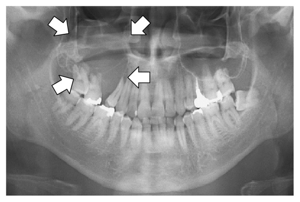

Generated Caption: 
This is a panoramic radiograph of the human head and neck, showing both the maxillary (upper) and mandibular (lower) dental arches from an anterior to posterior view.

**Key Features:**

- **Radiographic Type:** Panoramic X-ray — it captures the entire dentition, jaws, temporomandibular joints, sinuses, and surrounding bone structures.
  
- **Dental Architecture:**
  - The upper teeth are visible at the top half of the image; they appear as darker areas with white outlines representing enamel.
  - The lower teeth occupy the bottom portion of the image.
  -

Ground Truth:
Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).
TEST EXAMPLE 5


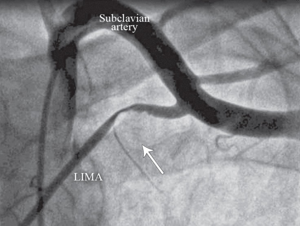

Generated Caption: 
This is a grayscale angiographic image, likely from a cardiac catheterization procedure, showing the proximal portion of the thoracic vasculature.

Key anatomical structures and annotations:

1. **Subclavian Artery**: A large, darkly contrasted vessel arching across the top-center of the frame. It's labeled with text “Subclavian artery” pointing to its course as it descends toward the heart region.
2. **LIMA (Left Internal Mammary Artery)**: This major coronary bypass graft vessel is shown branching off or running parallel to the subclavian artery’s path below it. The label

Ground Truth:
Anteroposterior coronary angiographic view of the subclavian artery and left internal mammary artery (LIMA), showing the proximal LIMA compression and severe flow interruption associated with the hyperabduction of left arm (The arrow indicates the area of the compression and the flow interruption.)
TEST EXAMPLE 10


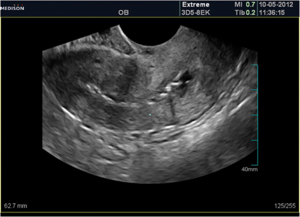

Generated Caption: 
This is a grayscale transvaginal ultrasound (OB) image, captured on a Medison system with the “Extreme 3D5-8EK” probe and dated October 5, 2012 at 11:36 AM.

**Image Orientation & Scale:**
The scan is displayed as an elliptical field of view typical for pelvic/obstetric ultrasounds.
A scale bar along the right side indicates depth from 40 mm to the top edge — suggesting it’s measuring depth within the pelvis or uterus.
At the bottom left corner, "62.7mm" likely denotes

Ground Truth:
Ultrasound shows irregular endometrial contour with typical adhesion appearnace.


In [ ]:
instruction = "Describe this medical image in detail."

# Test with 3 samples
test_indices = [0, 5, 10]

for idx in test_indices:

    print(f"TEST EXAMPLE {idx}")

    test_image = dataset[idx]["image"]
    ground_truth = dataset[idx]["caption"]

    # Show image
    display_image = test_image.copy()
    display_image.thumbnail((300, 300))
    display(display_image)

    # Format input
    messages = [{"role": "user", "content": [{"type": "image", "image": test_image}, {"type": "text", "text": instruction}]}]

    # Apply chat template
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Process inputs
    inputs = processor(text=[text], images=[test_image], padding=True, return_tensors="pt").to(model.device)

    print("Generated Caption: ")
    with torch.inference_mode():
        output = model.generate(**inputs, max_new_tokens=128, temperature=0.7, top_p=0.9,
            repetition_penalty=1.2, do_sample=True, use_cache=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id)

    generated_text = processor.decode(output[0], skip_special_tokens=True)

    # Extract assistant's response
    if "assistant" in generated_text:
        parts = generated_text.split("assistant")
        response = parts[-1].strip() if len(parts) > 1 else generated_text
    else:
        response = generated_text

    print(response)
    print("\nGround Truth:")
    print(ground_truth)

#### VLM Finetuning

Similar to the previous lecture, we will use Supervised Fine-Tuning (SFT) to refine the model parameters on the radiology dataset. The training arguments are explained in the first lecture on LLMs.

In [ ]:
# Training configuration
training_args = SFTConfig(
    output_dir="./qwen3-vlm-4b-radiology",
    # training steps
    max_steps=20,
    # Batch settings
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    # Learning rate
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    # Optimizer
    optim="adamw_torch_fused",
    weight_decay=0.01,
    max_grad_norm=0.3,
    # Precision
    bf16=True,
    # Logging
    logging_steps=2,
    report_to="none",
    # Dataset processing
    remove_unused_columns=False,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True})

In [ ]:
# Initialize trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    processing_class=processor,
    peft_config=lora_config,
)

Finetuning the model took close to 3 hours, where 20 steps used 2x16 samples, i.e., in total 640 samples were used, out of 1,800 available samples in the train dataset. One can conclude that VLM finetuning is more computationally intense than LLM finetuning. In this case, finetuning the model for 1 full epoch would have taken over 8 hours.

In [ ]:
# Training
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 151645, 'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
1,3.951800
2,3.935000
3,3.567900
4,2.895500
5,2.376200
6,1.949900
7,1.799600
8,1.489800
9,1.258400
10,1.118500


TrainOutput(global_step=20, training_loss=1.7231476455926895, metrics={'train_runtime': 11134.8345, 'train_samples_per_second': 0.057, 'train_steps_per_second': 0.002, 'total_flos': 6966597909897216.0, 'train_loss': 1.7231476455926895, 'epoch': 0.3407880724174654})

In [ ]:
# Save the finetuned model
output_dir = "./qwen3-vlm-4b-radiology-final"
trainer.model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)

#### Perform Inference with the Finetuned Model

Now that the VLM has been finetuned, let's test the model using the same examples from above, and check the generated responses.

In [ ]:
# Clear the training model from memory
from peft import PeftModel
del model
del trainer
torch.cuda.empty_cache()

In [ ]:
# Reload base model with bnb quantization
base_model = Qwen3VLForConditionalGeneration.from_pretrained("Qwen/Qwen3-VL-4B-Instruct",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16)

# Load the trained adapters
inference_model = PeftModel.from_pretrained(base_model, "./qwen3-vlm-4b-radiology-final/")

# Load processor
processor = AutoProcessor.from_pretrained("./qwen3-vlm-4b-radiology-final/", min_pixels=256*28*28, max_pixels=512*28*28)

# Perform inference
inference_model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3VLForConditionalGeneration(
      (model): Qwen3VLModel(
        (visual): Qwen3VLVisionModel(
          (patch_embed): Qwen3VLVisionPatchEmbed(
            (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
          )
          (pos_embed): Embedding(2304, 1024)
          (rotary_pos_emb): Qwen3VLVisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-23): 24 x Qwen3VLVisionBlock(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Qwen3VLVisionAttention(
                (qkv): Linear4bit(in_features=1024, out_features=3072, bias=True)
                (proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              )
              (mlp): Qwen3VLVisionMLP(
                (linear_fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
   

TEST EXAMPLE 0


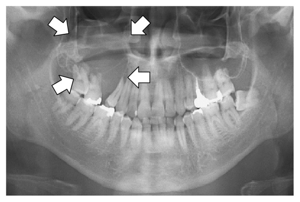

Generated Caption: 


KeyboardInterrupt: 

In [ ]:
instruction = "Describe this medical image in detail."

# Test with teh same 3 samples
test_indices = [0, 5, 10]

for idx in test_indices:

    print(f"TEST EXAMPLE {idx}")

    test_image = dataset[idx]["image"]
    ground_truth = dataset[idx]["caption"]

    # Show image
    display_image = test_image.copy()
    display_image.thumbnail((300, 300))
    display(display_image)

    # Format input
    messages = [{"role": "user", "content": [{"type": "image", "image": test_image}, {"type": "text", "text": instruction}]}]

    # Apply chat template
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Process inputs
    inputs = processor(text=[text], images=[test_image], padding=True, return_tensors="pt").to(inference_model.device)

    print("Generated Caption: ")
    with torch.inference_mode():
        output = inference_model.generate(**inputs, max_new_tokens=128, temperature=0.7, top_p=0.9,
            repetition_penalty=1.2, do_sample=True, use_cache=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id)

    generated_text = processor.decode(output[0], skip_special_tokens=True)

    # Extract assistant's response
    if "assistant" in generated_text:
        parts = generated_text.split("assistant")
        response = parts[-1].strip() if len(parts) > 1 else generated_text
    else:
        response = generated_text

    print(response)
    print("\nGround Truth:")
    print(ground_truth)

## Appendix: VLM Finetuning with Unsloth Library<a name='appendix:-vlm-finetuning-with-unsloth-library'></a>

**(The material in the Appendix is not required for quizzes and assignments.)**

This section presents another example of finetuning the Qwen3 VLM with the Unlsoth library [15]. The code with Unlsoth is simpler, and it is optimized for minimizing the memory use and computational resources.

In [1]:
# Install Unsloth
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.22.2

In [2]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Add LoRA adapters for parameter efficient finetuning allowing to train a small portion of all parameters. Unsloth also supports finetuning only the vision part of the model, only the language part, or both the vision and language parts.

In [3]:
# Prepare the model for LoRA finetuning
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [4]:
# Load the radiology dataset
from datasets import load_dataset
dataset = load_dataset("unsloth/Radiology_mini", split = "train")

Format the dataset for finetuning.

In [5]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [6]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [7]:
# Check the formatted dataset
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=657x442>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'}]}]}

Next, the model is trained for 60 steps. You can set `num_train_epochs=1 ` for longer finetuning.

In [8]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 16,
        warmup_steps = 3,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [9]:
# Train the model
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,3.280000
10,2.047400
15,1.527300
20,1.294400
25,1.268300
30,1.300300


Next, a response is generated with the finetuned model for the first radiology image.

In [12]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]

instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                   use_cache=True, do_sample=True, temperature=1.5, min_p=0.1)

Cephalometric X-ray showing the presence of supernumerary tooth on upper and lower incisors.<|im_end|>


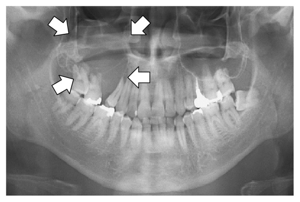

In [11]:
# Show image
display_image = image.copy()
display_image.thumbnail((300, 300))
display(display_image)

## References <a name='references'></a>

1. Mixture of Experts Model(MOE) in AI: What is it and How does it work?, by Sahin Ahmed, available at [https://blog.gopenai.com/mixture-of-experts-model-moe-in-ai-what-is-it-and-how-does-it-work-b845ed38a3ab](https://blog.gopenai.com/mixture-of-experts-model-moe-in-ai-what-is-it-and-how-does-it-work-b845ed38a3ab).
2. Transformer vs. Mixture of Experts in LLMs, by Avi Chawla, available at [https://www.dailydoseofds.com/p/transformer-vs-mixture-of-experts-in-llms/](https://www.dailydoseofds.com/p/transformer-vs-mixture-of-experts-in-llms/).
3. What is Mixture of Experts?, by Dave Bergmann, available at [https://www.ibm.com/think/topics/mixture-of-experts](https://www.ibm.com/think/topics/mixture-of-experts).
4. A Crash Course on Building RAG Systems - Part 1 (With Implementation), by Akshay Pachaar and Avi Chawla, available at [https://www.dailydoseofds.com/a-crash-course-on-building-rag-systems-part-1-with-implementations/](https://www.dailydoseofds.com/a-crash-course-on-building-rag-systems-part-1-with-implementations/).
5. Advanced NLP Fall 2025 Code, by Sean Welleck, available at [https://github.com/cmu-l3/anlp-fall2025-code/blob/main/10_rag/rag.ipynb](https://github.com/cmu-l3/anlp-fall2025-code/blob/main/10_rag/rag.ipynb).
6. Building a Simple RAG Application Using LlamaIndex, by Abid Ali Awan, available at [https://machinelearningmastery.com/building-a-simple-rag-application-using-llamaindex/](https://machinelearningmastery.com/building-a-simple-rag-application-using-llamaindex/).
7. RAG: a Simple Practical Example Using llama index and HuggingFace, by Mayada Khatib, available at [https://medium.com/@mayadakhatib/rag-a-simple-practical-example-using-llama-index-and-huggingface-fab3e5aa7442](https://medium.com/@mayadakhatib/rag-a-simple-practical-example-using-llama-index-and-huggingface-fab3e5aa7442).
8. Vision-language models (VLMs) Explained (pt. 1), by Sean Trott, available at [https://seantrott.substack.com/p/vision-language-models-vlms-explained](https://seantrott.substack.com/p/vision-language-models-vlms-explained).
9. CLIP: Connecting text and images, OpenAI, available at [https://openai.com/index/clip/](https://openai.com/index/clip/).
10. Vision Language Models (VLMs) Explained - GeeksForGeeks, available at [https://www.geeksforgeeks.org/artificial-intelligence/vision-language-models-vlms-explained/](https://www.geeksforgeeks.org/artificial-intelligence/vision-language-models-vlms-explained/).
11. Vision Language Models Explained - Hugging Face Blog, by Merve,
Edward Beeching, available at [https://huggingface.co/blog/vlms](https://huggingface.co/blog/vlms).
12. Understanding Vision-Language Models (VLMs): A Practical Guide, by Pietro Bolcato, available at [https://medium.com/@pietrobolcato/understanding-vision-language-models-vlms-a-practical-guide-8da18e9f0e0c](https://medium.com/@pietrobolcato/understanding-vision-language-models-vlms-a-practical-guide-8da18e9f0e0c).
13. What Are Vision Language Models, by NVIDIA, available at [https://www.nvidia.com/en-us/glossary/vision-language-models/](https://www.nvidia.com/en-us/glossary/vision-language-models/).
14. Vision Language Models, by Rohit Bandaru, available at [https://rohitbandaru.github.io/blog/Vision-Language-Models/](https://rohitbandaru.github.io/blog/Vision-Language-Models/).
15. Vision Fine-tuning, by Unsloth, available at [https://docs.unsloth.ai/basics/vision-fine-tuning](https://docs.unsloth.ai/basics/vision-fine-tuning)